# **Analise de temas narrativos e emocionais em  STAR WARS: THE CLONE WARS**

# 1. Metodologia

## Processamento textual
As legendas em formato SRT foram convertidas para texto contínuo, com remoção de timestamps e marcas de formatação.  
A segmentação em sentenças foi realizada com NLTK, priorizando legibilidade sem reconstrução sintática completa.

## Classificação temática
Foi utilizada classificação zero-shot (`facebook/bart-large-mnli`) para identificar a presença relativa de temas narrativos por episódio.

A opção por zero-shot permite:
- Evitar rotulação manual,
- Testar hipóteses temáticas flexíveis,
- Manter independência do domínio específico da série.

## Agregação temporal
Os scores foram agregados por temporada, utilizando média simples, com o objetivo de observar tendências relativas e não valores absolutos.

Os gráficos resultantes representam variações temáticas ao longo do tempo narrativo da série.

# 2. Configuração de ambiente e pré-requisitos
## 2.1 Importação de bilbliotecas

In [1]:
import os
import sys

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import pipeline
from nltk import sent_tokenize
import nltk
from time import time
import matplotlib.pyplot as plt
import torch
import re
import chardet
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))

from src.data_processing import load_and_process_subtitles
from src.visualization import (
plot_season_themes, plot_specific_theme_evolution, 
plot_themes_evolution
)

plt.style.use('bmh')

In [2]:
print(f"Dispositivo CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nome da GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda:0")
    print(f"Dispositivo configurado para: {device}")
else:
    device = torch.device("cpu")
    print("GPU não detectada. O código rodará na CPU.")

Dispositivo CUDA disponível: True
Nome da GPU: NVIDIA GeForce RTX 3060
Dispositivo configurado para: cuda:0


## 2.2 Download dos tokenizers do NLTK

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kzini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kzini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 3. Coleta e pré-processamento de dados

In [5]:
subtitles_path = sorted(glob("../data/subs/*.srt"))

In [6]:
subtitles_path[:5]

['../data/subs\\The Clone Wars Season 1 - 01.srt',
 '../data/subs\\The Clone Wars Season 1 - 02.srt',
 '../data/subs\\The Clone Wars Season 1 - 03.srt',
 '../data/subs\\The Clone Wars Season 1 - 04.srt',
 '../data/subs\\The Clone Wars Season 1 - 05.srt']

In [7]:
df = load_and_process_subtitles(subtitles_path)
df = df.sort_values(['season', 'episode']).reset_index(drop=True)
df.head()

,season,episode,script
0,1,1,A galaxy divided by war. Peaceful worlds must ...
1,1,2,The clone Starfleet is under siege. Dozens of ...
2,1,3,A deadly weapon unleashed. The Separatist batt...
3,1,4,Grievous in retreat! Before the battleship Mal...
4,1,5,Clone forces rally. As the war escalates in th...


In [8]:
print(f"Total de episódios: {len(df)}")
print(f"Temporadas: {df['season'].unique()}")
print(f"Episódios por temporada:")
print(df['season'].value_counts().sort_index())

Total de episódios: 133
Temporadas: [1 2 3 4 5 6 7]
Episódios por temporada:
season
1    22
2    22
3    22
4    22
5    20
6    13
7    12
Name: count, dtype: int64


## 4. Carregamento do modelo

In [9]:
from transformers import pipeline
theme_classifier = pipeline("zero-shot-classification",
                    model= 'facebook/bart-large-mnli',
                    device=device,
                    torch_dtype=torch.float16,
                    batch_size=8)

In [10]:
theme_classifier("The hyperdrive of the Millennium Falcon is malfunctioning during the escape from Hoth!",
    candidate_labels=["urgent", "not urgent", "rebel", "empire", "smuggler", "droid"],
    multi_label=False
)

{'sequence': 'The hyperdrive of the Millennium Falcon is malfunctioning during the escape from Hoth!',
 'labels': ['urgent', 'rebel', 'smuggler', 'empire', 'droid', 'not urgent'],
 'scores': [0.487782746553421,
  0.20979273319244385,
  0.1379217505455017,
  0.1297554075717926,
  0.026041574776172638,
  0.008705814369022846]}

## 5. Inferência e processamento de temas

In [11]:
def get_themes_clone_wars(script):
    script_sentences = sent_tokenize(script)

    script_batches = []
    sentence_batch_size = 25
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    emotion_output = theme_classifier(script_batches, themes, multi_label=True)

    emotions = {}
    for output in emotion_output:
        for label, score in zip(output['labels'], output['scores']):
            if score < 0.3:
                continue
            if label not in emotions:
                emotions[label] = []
            emotions[label].append(score)

    emotions = {key: np.mean(np.array(value)) for key, value in emotions.items()}
    return emotions

In [12]:
themes = [
    'war',
    'honor',
    'loyalty',
    'betrayal',
    'strategy',
    'sacrifice',
    'friendship',
    'hope',
    'corruption',
    'justice',
    'power',
    'duty',
]

In [13]:
tqdm.pandas()

season_themes = {}

for season in df['season'].unique():
    print(f"Processando Temporada {season}...")
    season_df = df[df['season'] == season]

    season_emotions = season_df['script'].progress_apply(get_themes_clone_wars)
    emotion_df_season = pd.DataFrame(season_emotions.tolist())

    theme_scores = emotion_df_season.mean().reset_index()
    theme_scores.columns = ['theme', 'score']
    theme_scores = theme_scores.sort_values('score', ascending=False)

    season_themes[season] = theme_scores
    print(f"Temporada {season} concluída!")

Processando Temporada 1...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:37<00:00,  1.69s/it]


Temporada 1 concluída!
Processando Temporada 2...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:35<00:00,  1.63s/it]


Temporada 2 concluída!
Processando Temporada 3...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:32<00:00,  1.47s/it]


Temporada 3 concluída!
Processando Temporada 4...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:30<00:00,  1.38s/it]


Temporada 4 concluída!
Processando Temporada 5...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.50s/it]


Temporada 5 concluída!
Processando Temporada 6...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:20<00:00,  1.61s/it]


Temporada 6 concluída!
Processando Temporada 7...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.52s/it]

Temporada 7 concluída!


## 6. Visualização de temas

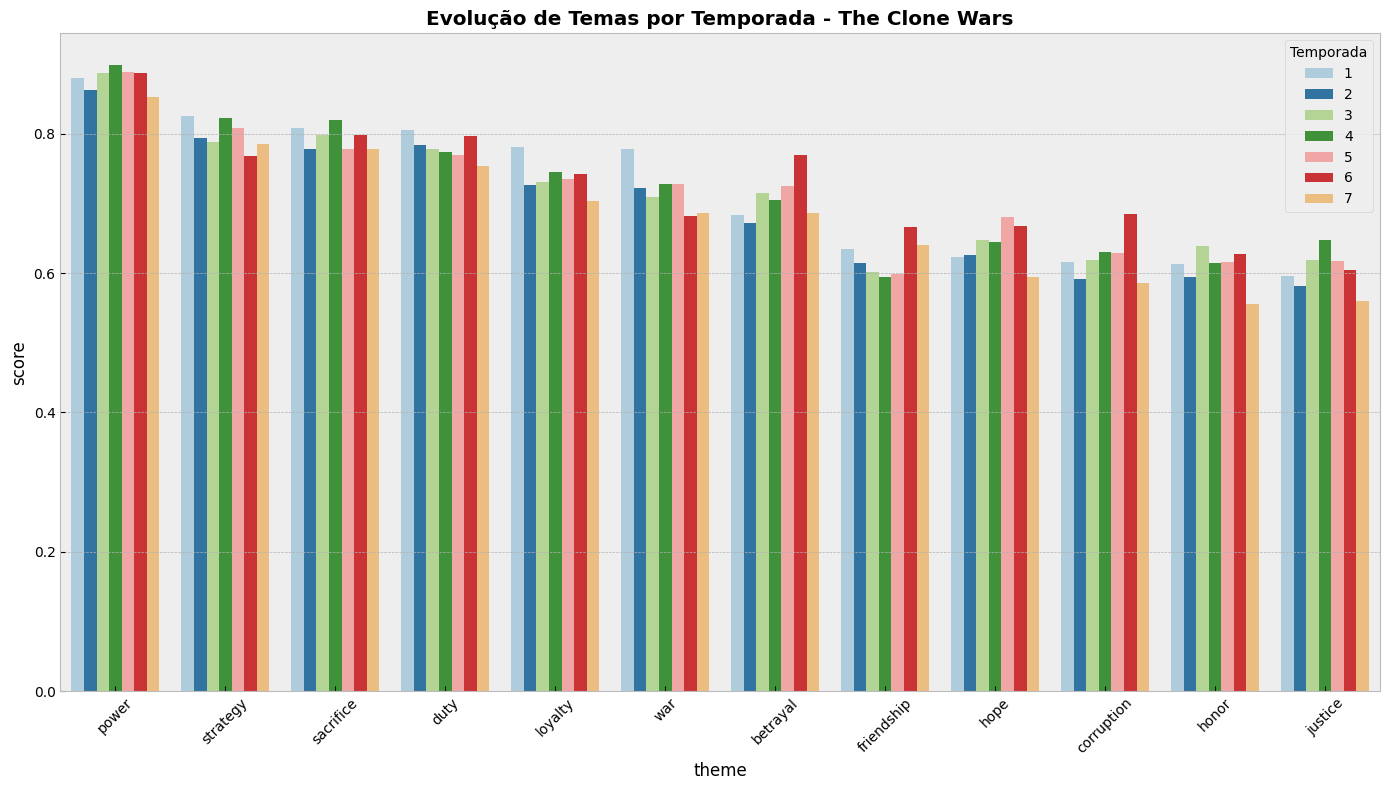

In [14]:
sns.set_palette("tab20", len(themes))
plot_season_themes(season_themes, themes)

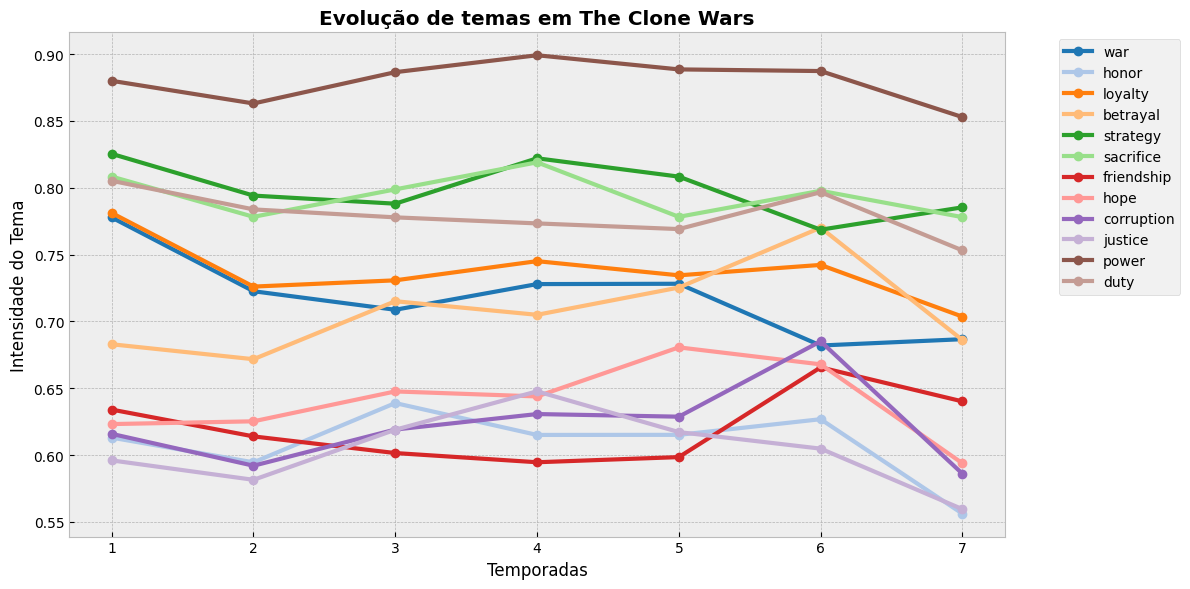

In [15]:
plot_themes_evolution(season_themes, themes)

## 7. Detecção de temas específicos (Lado Sombrio)

In [16]:
dark_side_themes = {
  'darkness': {
      'weight': 2.0,
      'keywords': ['dark side', 'sith', 'darth', 'phantom', 'shadow', 'evil',
                  'darkness', 'black', 'night', 'sinister', 'malevolent']
  },
  'corruption': {
      'weight': 1.8,
      'keywords': ['corruption', 'corrupt', 'bribe', 'greed', 'selfish',
                  'decay', 'rot', 'venal', 'avarice', 'cupidity']
  },
  'betrayal': {
      'weight': 2.2,
      'keywords': ['betrayal', 'betray', 'treason', 'traitor', 'deceive',
                  'treachery', 'backstab', 'double-cross', 'duplicity',
                  'order sixty-six', 'order 66']
  },
  'power': {
      'weight': 2.0,
      'keywords': ['power', 'dominate', 'control', 'rule', 'supreme',
                  'command', 'authority', 'mastery', 'dominance', 'overpower']
  },
  'fear': {
      'weight': 1.7,
      'keywords': ['fear', 'terror', 'afraid', 'dread', 'intimidate',
                  'horror', 'panic', 'scare', 'fright', 'apprehension']
  },
  'anger': {
      'weight': 1.9,
      'keywords': ['anger', 'rage', 'hate', 'wrath', 'fury', 'ire',
                  'outrage', 'resentment', 'hostility', 'vengeance']
  },
  'manipulation': {
      'weight': 1.8,
      'keywords': ['manipulate', 'deceive', 'trick', 'scheme', 'plot',
                  'exploit', 'maneuver', 'connive', 'conspire', 'intrigue',
                  'the dark side of the force']
  },
  'death': {
      'weight': 2.1,
      'keywords': ['kill', 'die', 'death', 'murder', 'assassinate',
                  'slay', 'destroy', 'eliminate', 'execute']
  },
  'suffering': {
      'weight': 1.9,
      'keywords': ['pain', 'suffer', 'torment', 'agony', 'anguish',
                  'misery', 'torture', 'despair']
  }
}

In [17]:
def detect_themes_presence(script, themes):
    if not script or not script.strip():
        return 0.0

    sentences = sent_tokenize(script)
    total_score = 0.0
    counted_sentences = 0

    for sentence in sentences:
        sentence_lower = sentence.lower()
        if len(sentence_lower.split()) < 4:
            continue

        sentence_score = 0.0
        for theme, data in themes.items():
            for keyword in data['keywords']:
                if re.search(r'\b{}\b'.format(re.escape(keyword)), sentence_lower):
                    sentence_score += data['weight']
                    break

        if sentence_score > 0:
            total_score += sentence_score
            counted_sentences += 1

    if counted_sentences == 0:
        return 0.0

    normalized_score = total_score / counted_sentences
    return normalized_score

In [18]:
df['theme_score'] = df['script'].progress_apply(detect_themes_presence, themes=dark_side_themes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:04<00:00, 29.92it/s]


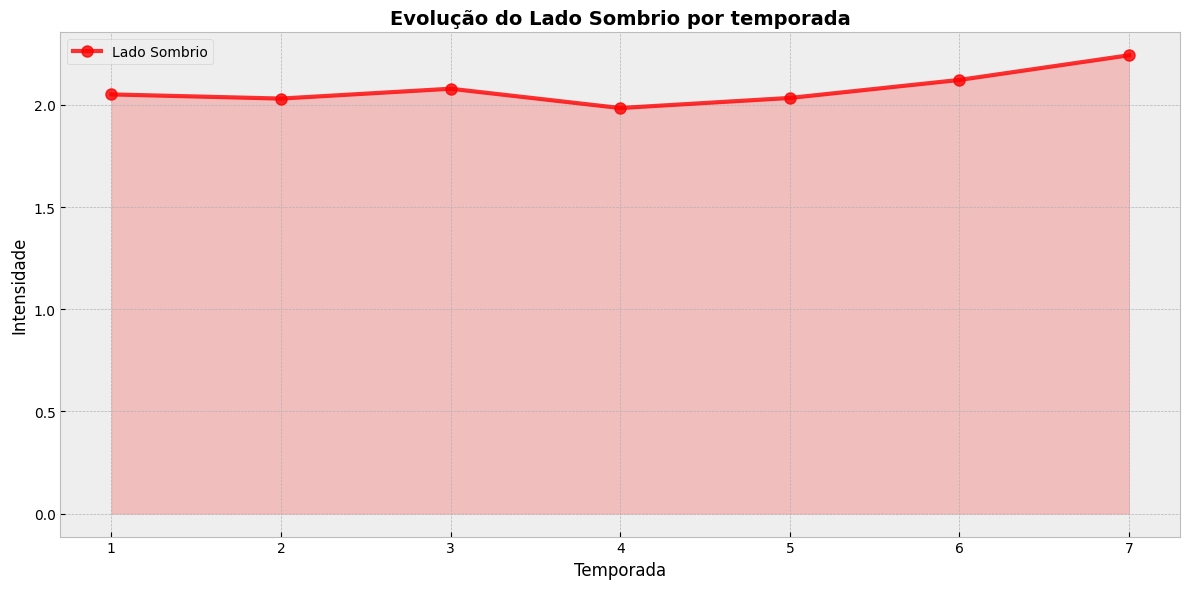

In [19]:
plot_specific_theme_evolution(df, 'Lado Sombrio', 'red')

## Autor

**Desenvolvido por:**  
Bruno Casini

**GitHub:**  
[<img src="https://img.icons8.com/ios-filled/20/000000/github.png"/> GitHub](https://github.com/kzini)  
`https://github.com/kzini`

**LinkedIn:**  
[<img src="https://img.icons8.com/ios-filled/20/000000/linkedin.png"/> LinkedIn](https://www.linkedin.com/in/kzini)  
`https://www.linkedin.com/in/kzini`